In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import time
from sklearn.model_selection import train_test_split
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [2]:
# Download MNIST dataset and normalize it
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

# Convert to NumPy arrays
train_images = train_dataset.data.numpy().reshape(-1, 28*28) / 255.0
train_labels = train_dataset.targets.numpy()

test_images = test_dataset.data.numpy().reshape(-1, 28*28) / 255.0
test_labels = test_dataset.targets.numpy()

In [3]:
class Linear:
    """
    A class defining a linear layer in an MLP: 

    Init: 
    * Weights [out x in] drawn from N(0, 1) scaled by sqrt 2/in  for Kaiming - He init.
    https://arxiv.org/abs/1502.01852v1 (Kaiming He et. al. - used for initializing, ReLU, and LeakyReLU)
    * Biases [out, 1] populated with zeros (0's), the popped 1 is for shape

    Forward: 
    * cache_input saves layer input X for backward pass and backprop
    * w@x+b does linear function from in_dim to out_dim

    Backward:
    * recalls cached X and extracts data dimension (X.shape[1])
    * solves for gradients in W and b, (dW and db) and updates via backpropagation of errors (chain-rule)

    Params: 
    * returns the parameters dictionary

    grads: 
    * returns the gradients dictionary
    """
    def __init__(self, in_dim, out_dim):

        self.W = np.random.randn(out_dim, in_dim) * np.sqrt(2. / in_dim) 
        self.b = np.zeros((out_dim, 1))
        self.dW = None
        self.db = None
        self.cache_input = None

    def forward(self, X):
        self.cache_input = X
        return self.W @ X + self.b

    def backward(self, dZ):
        A_prev = self.cache_input
        m = A_prev.shape[1]
        self.dW = (1/m) * dZ @ A_prev.T
        self.db = (1/m) * np.sum(dZ, axis=1, keepdims=True)
        return self.W.T @ dZ

    def params(self):
        return {"W": self.W, "b": self.b}

    def grads(self):
        return {"dW": self.dW, "db": self.db}

class ReLU:
    """
    ReLU activation function (https://arxiv.org/abs/1502.01852v1, Kaiming He et. al.): 
    ReLU(x) = max(0, x)
    """
    def __init__(self):
        self.cache = None

    def forward(self, Z):
        self.cache = Z
        return np.maximum(0, Z)

    def backward(self, dA):
        Z = self.cache
        return dA * (Z > 0)

class LeakyReLU:
    """
    LeakyReLU activation function (https://arxiv.org/abs/1502.01852v1, Kaiming He et. al.): 
    LeakyReLU(x) = x if x>=0, or, alpha * x if x < 0
    """
    def __init__(self, alpha=0.2):
        self.alpha = alpha

    def forward(self, X):
        self.input = X
        return np.where(X > 0, X, self.alpha * X)

    def backward(self, d_out):
        return d_out * np.where(self.input > 0, 1, self.alpha)

    def parameters(self):
        return []

    def grads(self):
        return []

class Softmax:
    """
    Softmax activation function. Converts input into a vector of probabilities. 
    """
    def forward(self, Z):
        expZ = np.exp(Z - np.max(Z, axis=0, keepdims=True))
        return expZ / np.sum(expZ, axis=0, keepdims=True)

    def backward(self, Y_hat, Y_true):
        Y = np.zeros_like(Y_hat)
        Y[Y_true, np.arange(Y_true.size)] = 1
        return Y_hat - Y  # derivative of cross-entropy + softmax

class BatchNorm1d:
    """
    Batch Normalization - 1D case: 
    Tracks mean and variance, normalizes them, then models them linearly, accelerating convergence. 
    https://arxiv.org/abs/1502.03167,  Sergey Ioffe et. al. 

    Init: 
    * creates variables and populates with zero placeholders 

    Forward:
    * finds mean and variance of input over the batch
    * Normalizes
    * updates running mean and variance 

    Backwards:
    * backpropagates error through gamma and beta
    * returns error for layer above
    """
    def __init__(self, dim, momentum=0.9, eps=1e-5):
        self.dim = dim
        self.eps = eps
        self.momentum = momentum

        # Learnable parameters
        self.gamma = np.ones((dim, 1))
        self.beta = np.zeros((dim, 1))

        # Running statistics for inference
        self.running_mean = np.zeros((dim, 1))
        self.running_var = np.ones((dim, 1))

        self.training = True

    def forward(self, X):
        self.input = X
        if self.training:
            self.batch_mean = np.mean(X, axis=1, keepdims=True)
            self.batch_var = np.var(X, axis=1, keepdims=True)

            self.norm = (X - self.batch_mean) / np.sqrt(self.batch_var + self.eps)
            out = self.gamma * self.norm + self.beta

            # Update running stats
            self.running_mean = self.momentum * self.running_mean + (1 - self.momentum) * self.batch_mean
            self.running_var = self.momentum * self.running_var + (1 - self.momentum) * self.batch_var
        else:
            norm = (X - self.running_mean) / np.sqrt(self.running_var + self.eps)
            out = self.gamma * norm + self.beta

        return out

    def backward(self, d_out):
        N = d_out.shape[1]

        d_norm = d_out * self.gamma
        d_var = np.sum(d_norm * (self.input - self.batch_mean) * -0.5 * (self.batch_var + self.eps) ** -1.5, axis=1, keepdims=True)
        d_mean = np.sum(d_norm * -1 / np.sqrt(self.batch_var + self.eps), axis=1, keepdims=True) + d_var * np.mean(-2 * (self.input - self.batch_mean), axis=1, keepdims=True)

        d_input = d_norm / np.sqrt(self.batch_var + self.eps) + d_var * 2 * (self.input - self.batch_mean) / N + d_mean / N
        self.dgamma = np.sum(d_out * self.norm, axis=1, keepdims=True)
        self.dbeta = np.sum(d_out, axis=1, keepdims=True)

        return d_input

    def parameters(self):
        return [self.gamma, self.beta]

    def grads(self):
        return [self.dgamma, self.dbeta]

    def train(self):
        self.training = True

    def eval(self):
        self.training = False

class SGDOptimizer:
    """
    Classic naieve stochastic gradient descent alpgorithm. 
    Take a small step with slight stochasticity in the direction of the gradient
    """
    def __init__(self, parameters, learning_rate=0.01, jitter = 1e-4):
        self.parameters = parameters
        self.lr = learning_rate
        self.jitter = jitter
    
    def step(self, grads):
        for param_key in self.parameters:
            grad_key = "d" + param_key  # e.g. "W1" -> "dW1"
            if grad_key in grads:
                self.parameters[param_key][:] -= (self.lr + np.random.randn(1) * self.jitter) * grads[grad_key]


class AdamOptimizer:
    """
    Adam Optimizer method from https://arxiv.org/abs/1412.6980, Diederik P. Kingma & Jimmy Ba

    Init:
    * populates params with presets/settings

    Step: 
    * gets gradients
    * updates mean and variance moments (running means)
    * steps along gradient weighted by bias corrected moments
    """
    def __init__(self, parameters, learning_rate=0.001, beta1=0.9, beta2=0.999, epsilon=1e-8):
        self.parameters = parameters
        self.lr = learning_rate
        self.beta1 = beta1
        self.beta2 = beta2
        self.eps = epsilon
        self.t = 0

        # Initialize moment estimates
        self.m = {key: np.zeros_like(value) for key, value in parameters.items()}
        self.v = {key: np.zeros_like(value) for key, value in parameters.items()}

    def step(self, grads):
        self.t += 1
        for param_key in self.parameters:
            grad_key = "d" + param_key
            if grad_key not in grads:
                continue
    
            grad = grads[grad_key]
    
            # Update moments
            self.m[param_key] = self.beta1 * self.m[param_key] + (1 - self.beta1) * grad
            self.v[param_key] = self.beta2 * self.v[param_key] + (1 - self.beta2) * (grad ** 2)
    
            # Bias correction
            m_hat = self.m[param_key] / (1 - self.beta1 ** self.t)
            v_hat = self.v[param_key] / (1 - self.beta2 ** self.t)
    
            # Update parameters
            self.parameters[param_key][:] -= self.lr * m_hat / (np.sqrt(v_hat) + self.eps)



class NeuralNetwork:
    """
    Neural network: 
    * compiles the layers (seperate classes) sequentially and initializes them 
    * exectues forward and backward passes
    * handles passing between layers on forward and backward passes
    """
    def __init__(self, layers):
        self.layers = layers

    def forward(self, X):
        A = X.T
        for layer in self.layers:
            A = layer.forward(A)
        return A

    def backward(self, Y_hat, Y_true):
        dA = self.layers[-1].backward(Y_hat, Y_true)
        for layer in reversed(self.layers[:-1]):
            dA = layer.backward(dA)

    def get_all_params_and_grads(self):
        params = {}
        grads = {}
        count = 1
        for layer in self.layers:
            if hasattr(layer, 'params'):
                p = layer.params()
                g = layer.grads()
                params[f"W{count}"] = p["W"]
                params[f"b{count}"] = p["b"]
                grads[f"dW{count}"] = g["dW"]
                grads[f"db{count}"] = g["db"]
                count += 1
        return params, grads

def cross_entropy_loss(Y_hat, Y_true):
    m = Y_true.shape[0]
    log_likelihood = -np.log(Y_hat[Y_true, np.arange(m)] + 1e-9)
    return np.sum(log_likelihood) / m

def compute_accuracy(Y_hat, Y_true):
    preds = np.argmax(Y_hat, axis=0)
    return np.mean(preds == Y_true)

def train(model, optimizer, X_train, y_train, X_test, y_test, 
          epochs=5, batch_size=64):
    """
    A training loop for a neural network (above) composed of layers (above) to classify MNIST digits.
    Batches data, trains for a specified number of epochs. 
    
    Returns the training and validation losses, as well as time elapsed per epoch. 
    
    Loss: cross entropy
    """
    num_samples = X_train.shape[0]
    
    val_losses = []
    val_accs = []

    train_losses = []
    train_accs = []
    
    for epoch in range(epochs):
        start_time = time.time()
        permutation = np.random.permutation(num_samples)
        X_train = X_train[permutation]
        y_train = y_train[permutation]

        epoch_loss = 0
        epoch_acc = 0
        for i in range(0, num_samples, batch_size):
            X_batch = X_train[i:i+batch_size]
            y_batch = y_train[i:i+batch_size]
            if X_batch.shape[0] == 0:
                continue

            # Forward pass
            Y_hat = model.forward(X_batch)
            loss = cross_entropy_loss(Y_hat, y_batch)
            acc = compute_accuracy(Y_hat, y_batch)

            # Backward pass
            model.backward(Y_hat, y_batch)
            _, grads = model.get_all_params_and_grads()
            optimizer.step(grads)

            epoch_loss += loss * X_batch.shape[0]
            epoch_acc += acc * X_batch.shape[0]
        
        avg_loss = epoch_loss / num_samples
        avg_acc = epoch_acc / num_samples

        # Evaluation
        Y_test_hat = model.forward(X_test)
        test_loss = cross_entropy_loss(Y_test_hat, y_test)
        test_acc = compute_accuracy(Y_test_hat, y_test)

        val_losses.append(test_loss)
        val_accs.append(test_acc)

        train_losses.append(avg_loss)
        train_accs.append(avg_acc)
        
        end_time = time.time()
        
        print(f"Epoch {epoch+1}/{epochs} | "
              f"Train Loss: {avg_loss:.4f}, Acc: {avg_acc:.4f} | "
              f"Test Loss: {test_loss:.4f}, Acc: {test_acc:.4f} | Took: {(end_time - start_time):.2f}s")

    # Optional: Plot training curves
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.plot(train_accs, label='Train Acc')
    plt.plot(val_accs, label='Val Acc')
    plt.xlabel("Epoch")
    plt.legend()
    plt.title("Training Progress")
    plt.show()


# Demo

Epoch 1/5 | Train Loss: 0.2683, Acc: 0.9208 | Test Loss: 0.1525, Acc: 0.9536 | Took: 1.32s
Epoch 2/5 | Train Loss: 0.1381, Acc: 0.9585 | Test Loss: 0.1226, Acc: 0.9609 | Took: 1.78s
Epoch 3/5 | Train Loss: 0.1062, Acc: 0.9673 | Test Loss: 0.1114, Acc: 0.9671 | Took: 1.52s
Epoch 4/5 | Train Loss: 0.0912, Acc: 0.9714 | Test Loss: 0.1030, Acc: 0.9679 | Took: 1.34s
Epoch 5/5 | Train Loss: 0.0784, Acc: 0.9737 | Test Loss: 0.1004, Acc: 0.9695 | Took: 1.36s


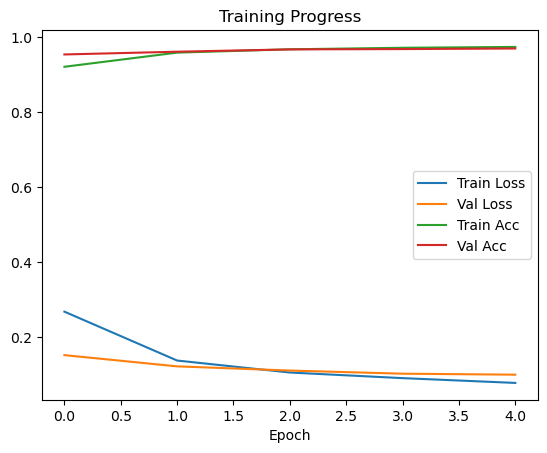

In [9]:
X_train, X_val, Y_train, Y_val = train_test_split(train_images, train_labels, test_size=0.2, random_state=42)

# Create network with hidden dim 64
layers = [
    Linear(784, 64),
    LeakyReLU(),
    Linear(64, 32),
    BatchNorm1d(32),
    LeakyReLU(),
    Linear(32, 10),
    Softmax()
]
model = NeuralNetwork(layers)

# Initialize optimizer
params, _ = model.get_all_params_and_grads()
optimizer = AdamOptimizer(params, learning_rate=0.01) 
# optimizer = SGDOptimizer(params, learning_rate=0.01)

train(model, optimizer, X_train, Y_train, X_val, Y_val, epochs=5, batch_size=64)

In [10]:
def test_model(network, X_test, Y_test): 
    """
    A function to test a neural network model on MNIST digit classification given a test dataset. 
    """
    Y_pred_probs = network.forward(X_test)
    Y_pred = np.argmax(Y_pred_probs, axis=0)
    accuracy = np.mean(Y_pred == Y_test)
    print(f"Test Accuracy: {accuracy:.4f} or {accuracy * 100 :.2f}%")
    
    return Y_pred

def show_examples(X, Y_true, Y_pred, correct=True, n=5):
    """
    A function to visualize model performance by showing first n examples of correct and incorrect classifications
    """
    indices = [i for i in range(len(Y_true)) if (Y_pred[i] == Y_true[i]) == correct]
    selected = random.sample(indices, min(n, len(indices)))

    plt.figure(figsize=(10, 4))
    for i, idx in enumerate(selected):
        plt.subplot(1, n, i+1)
        plt.imshow(X[idx].reshape(28, 28), cmap='gray')
        plt.axis('off')
        plt.title(f"Label: {Y_true[idx]}\nPred: {Y_pred[idx]}")
    plt.suptitle("Correctly Classified" if correct else "Misclassified", fontsize=14)
    plt.show()


Test Accuracy: 0.9718 or 97.18%


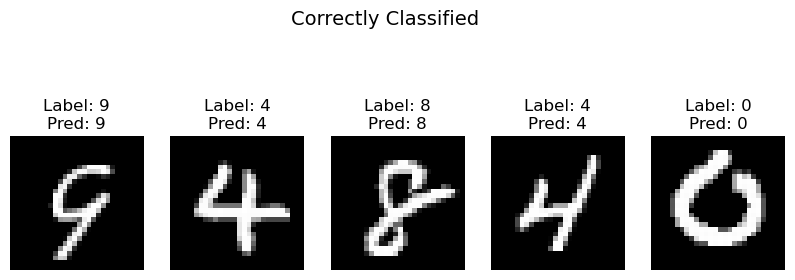

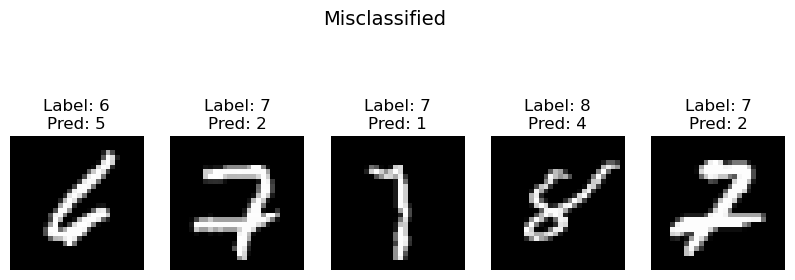

In [11]:
# Evaluate on test set
Y_test_pred = test_model(model, test_images, test_labels)

# Show correct and incorrect predictions
show_examples(test_images, test_labels, Y_test_pred, correct=True, n=5)
show_examples(test_images, test_labels, Y_test_pred, correct=False, n=5)

# Demo 2

Epoch 1/5 | Train Loss: 0.9841, Acc: 0.7690 | Test Loss: 0.6344, Acc: 0.8708 | Took: 2.65s
Epoch 2/5 | Train Loss: 0.5501, Acc: 0.8866 | Test Loss: 0.4511, Acc: 0.9005 | Took: 0.74s
Epoch 3/5 | Train Loss: 0.4258, Acc: 0.9036 | Test Loss: 0.3680, Acc: 0.9136 | Took: 1.23s
Epoch 4/5 | Train Loss: 0.3612, Acc: 0.9149 | Test Loss: 0.3217, Acc: 0.9210 | Took: 0.67s
Epoch 5/5 | Train Loss: 0.3178, Acc: 0.9240 | Test Loss: 0.2896, Acc: 0.9264 | Took: 0.65s


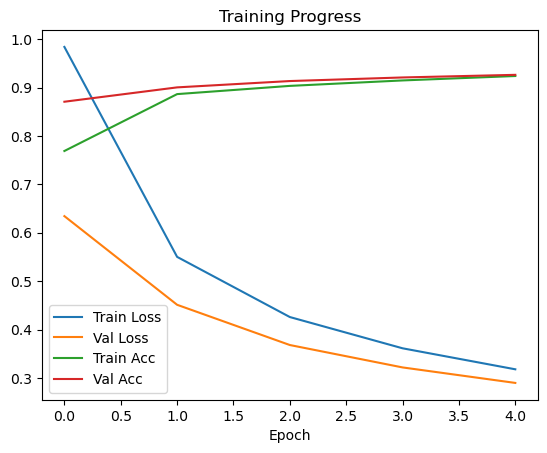

In [16]:
X_train, X_val, Y_train, Y_val = train_test_split(train_images, train_labels, test_size=0.2, random_state=42)

# Create network with hidden dim 64
layers = [
    Linear(784, 32),
    ReLU(),
    Linear(32, 16),
    BatchNorm1d(16),
    ReLU(),
    Linear(16, 10),
    Softmax()
]
model = NeuralNetwork(layers)

# Initialize optimizer
params, _ = model.get_all_params_and_grads()
# optimizer = AdamOptimizer(params, learning_rate=0.01) 
optimizer = SGDOptimizer(params, learning_rate=0.01)

train(model, optimizer, X_train, Y_train, X_val, Y_val, epochs=5, batch_size=64)

Test Accuracy: 0.9292 or 92.92%


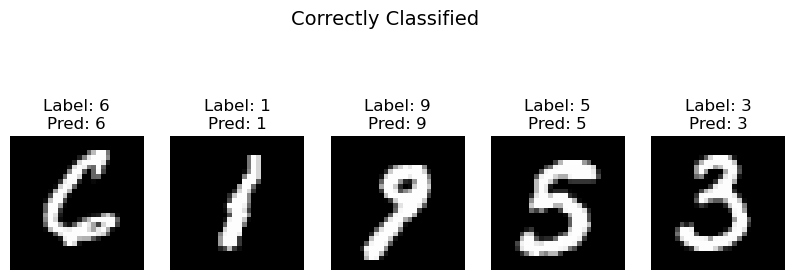

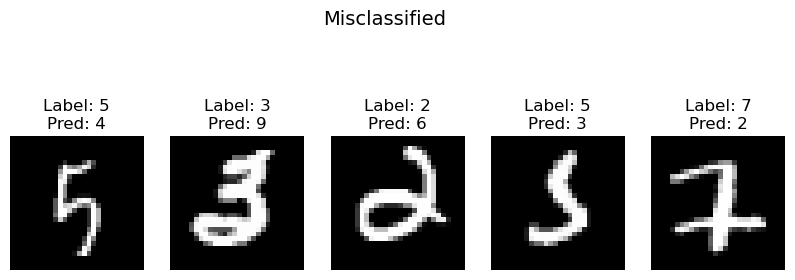

In [18]:
# Evaluate on test set
Y_test_pred = test_model(model, test_images, test_labels)

# Show correct and incorrect predictions
show_examples(test_images, test_labels, Y_test_pred, correct=True, n=5)
show_examples(test_images, test_labels, Y_test_pred, correct=False, n=5)